In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian

THRESHOLD = 100
MAX_PIXEL_VALUE = 255

plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (15, 10)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
# rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])



In [3]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, th=THRESHOLD, PRUEBA=False, nombre='BINARY'):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    # esto cierra los globitos, es lo que faltaba antes:
    # for c in np.unique(x):
    #     r = np.where(sk[:, c]!=0)[0]
    #     for p in r:
    #         sk[p, c] = 0
    #     sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

# Pruebas de una captura

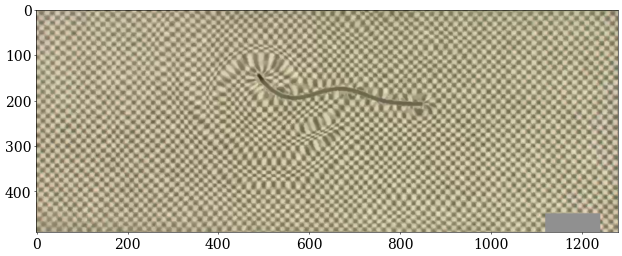

In [3]:
im = skimage.io.imread(f'capture-{FILENAME}-color.tiff')
plt.imshow(im)
im_copy = im.copy()

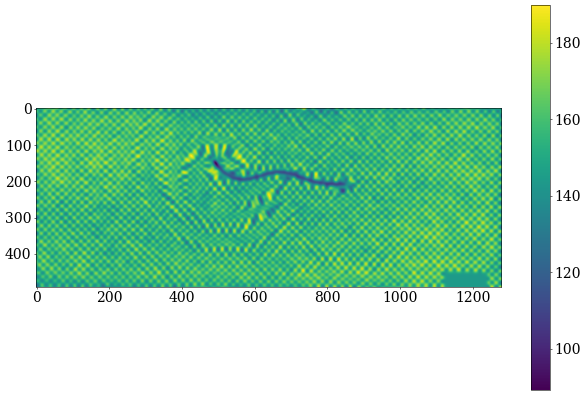

In [4]:
# ref_sobel = sobel(im)
ref_gray = gris(im)

ref_gaussian = gaussian(ref_gray, 4)*255

plt.figure()
plt.imshow(ref_gaussian)
plt.colorbar()


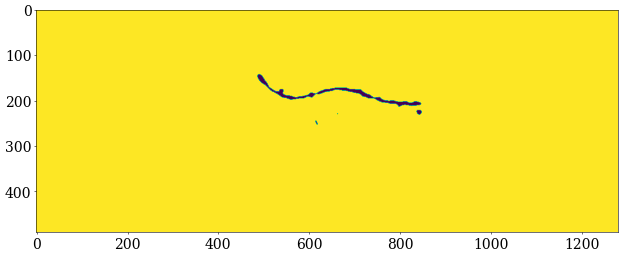

In [5]:
ref_binary = binarize(ref_gaussian, th=120)

plt.figure()
plt.imshow(ref_binary)

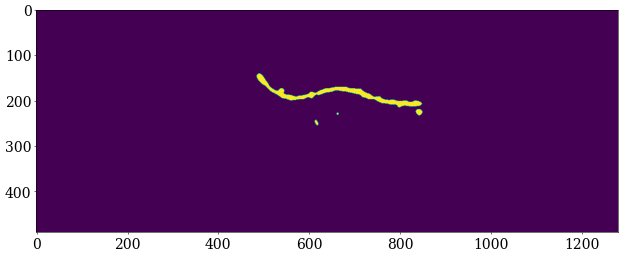

In [6]:
ref_clear = binary_erosion(ref_binary)
ref_clear = binary_erosion(ref_clear)
ref_clear_mask = 1-binary_opening(ref_clear)
ref_clear = ref_clear_mask*255
# ref_clear = cv.bitwise_not(ref_clear)

plt.figure()
plt.imshow(ref_clear)

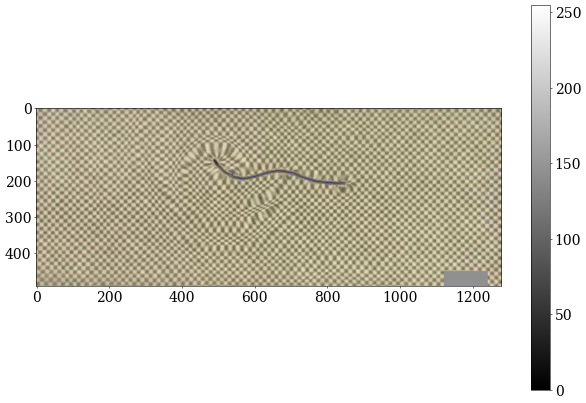

In [7]:
ref_sk = skeletonize(ref_clear)
y, x = np.where(ref_sk!=0)
im_copy[y, x] = [0,0,255]

plt.figure()
plt.imshow(im_copy, cmap='gray')
plt.colorbar()

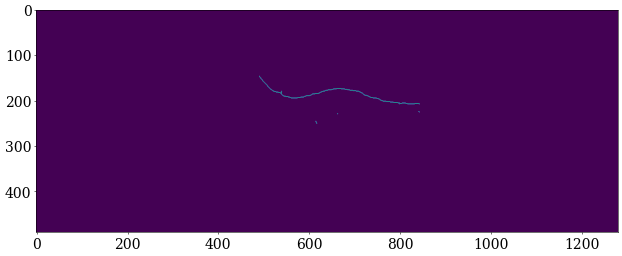

In [8]:
plt.imshow(ref_sk)

# Automatización

In [5]:
from skimage.morphology import remove_small_holes, binary_dilation, binary_closing, area_closing

In [32]:
def find(frame):
    y, x = np.where(frame==0)
    x_head = np.min(x)
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            ret, frame = vs.read()
            i+=1
            if i >=433:
                if ret:
                    frame = cortar(frame, limites)
                    frame_gray = gris(frame)
                    frame_gaussian = gaussian(frame_gray, 4)*255
                    frame_binary = binarize(frame_gaussian, th=100)
    
                    # frame_binary = binary_erosion(binary_erosion(frame_binary))
                    # frame_clear = (1-binary_opening(frame_binary))*255
                    # frame_sk = skeletonize(frame_clear)
                    
                    # y_sk, x_sk = np.where(frame_sk!=0)
                    # im_copy[y_sk, x_sk] = [0,0,255]
                    
                    mask = frame_binary>0
                    frame_binary = remove_small_holes(mask,20)*255
                    frame_binary = binary_closing(frame_binary)
                    
                    try:
                        x, y, x_head, y_head = find(frame_binary)
                        pos_x.append(x_head)
                        pos_y.append(y_head)
                        if SHOW:
                            frame[y, x] = [0, 255, 0]
                            # frame[y_sk, x_sk] = [0,0,255]
                            frame = cv.circle(frame, (x_head, y_head), radius=2, color=(0, 0, 255), thickness=-1)
                            cv.imshow('frame', frame)
                    except:
                        break
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    break
        cv.destroyAllWindows()
        vs.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

In [33]:
FILENAME='P1-2V-9Hz-cut (2)'
vs = cv.VideoCapture('videos\\FCD\\P1\\P1-2V-9Hz.mp4')
lim = [0, 1280, 0, 720]
t,x,y = tracker(vs, lim, SHOW=True)

In [303]:
FILENAME='P1-2V-9Hz-cut (2)'
camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax

vs = cv.VideoCapture(f'videos/FCD/P1/{FILENAME}.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret:
        # frame[camo_mask[0]:camo_mask[1],camo_mask[2]:camo_mask[3]] = 0
        # frame = binarize(gris(frame[110:600,:]),threshold=160)
        if i==434:
            ref_frame = frame
            cv.imwrite(f'{i}.jpg', ref_frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [304]:
vs.release()

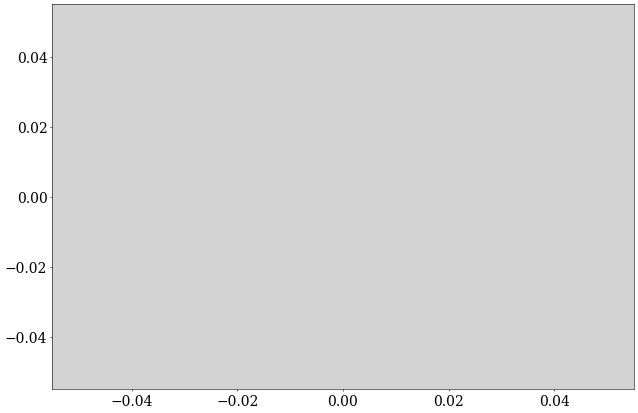

In [ ]:
plt.plot(head_x)

# Pruebas código de Pablo

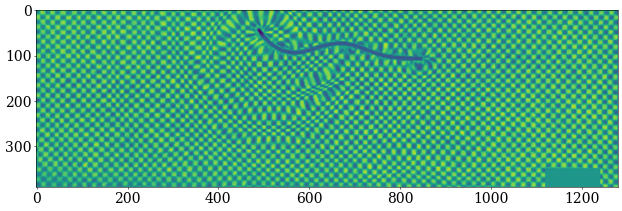

In [200]:
im = skimage.io.imread('capture-P1-2V-9Hz-color.tiff')
# im = skimage.io.imread('P1-capture.jpg')
im = np.mean(im[100:600,:,:],axis=2)
plt.imshow(im)

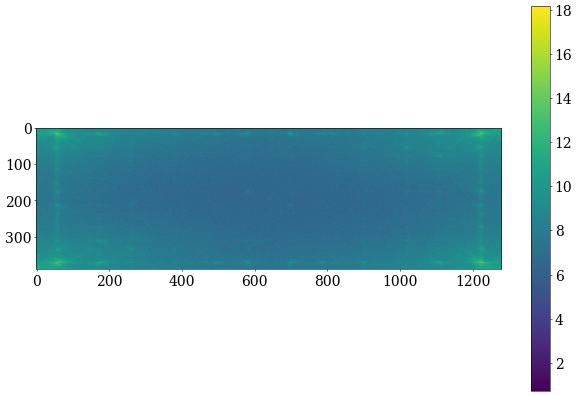

In [201]:
ft = np.fft.fft2(im)
plt.figure()
plt.imshow(np.log(np.abs(ft)))
plt.colorbar()

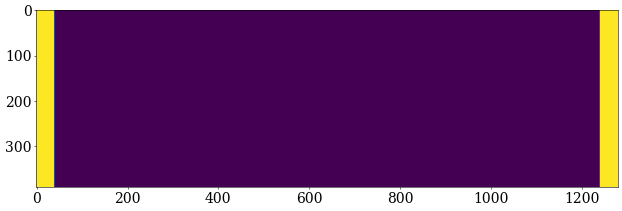

In [202]:
filt = np.zeros_like(im)
# esto es robusto: el filtro puede cambiar ancho entre 10 y 50!
# N = 10
N = 40
filt[:,0:N] = 1
filt[:,-N:] = 1
plt.imshow(filt)

C:\Users\pauli\AppData\Local\Temp\ipykernel_23328\98459067.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  rec = np.fft.ifft2(ftf).astype(float)


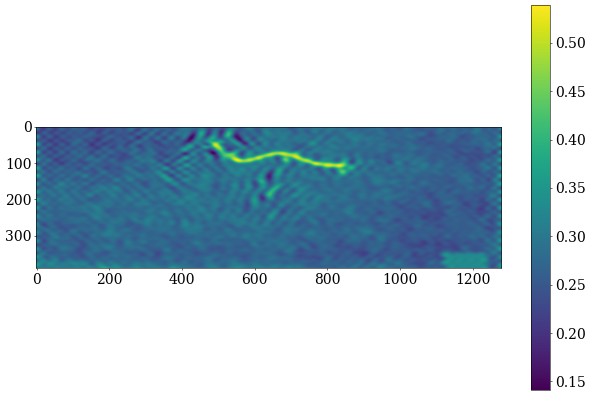

In [203]:
# vamos con la FTP 2D
ftf = ft*filt
# plt.imshow(ftf)
rec = np.fft.ifft2(ftf).astype(float)
rec = rec/np.max(rec)



rec = 1-rec
# rec = skimage.morphology.dilation(rec)
# rec = skimage.morphology.dilation(rec)
# rec = skimage.filters.gaussian(rec, 4)
# rec = skimage.filters.roberts(rec)
# rec = skimage.morphology.dilation(rec)
# rec = skimage.morphology.dilation(rec)
plt.figure()
plt.imshow(rec)
plt.colorbar()

[[0.25136644 0.24904408 0.24629442 ... 0.26411612 0.26356996 0.26301174]
 [0.26483846 0.26226642 0.25917745 ... 0.27556156 0.2756043  0.27552157]
 [0.27846126 0.27564155 0.27221542 ... 0.28712733 0.28776068 0.28815558]
 ...
 [0.32229035 0.32119123 0.31989934 ... 0.32367022 0.32464134 0.32532663]
 [0.31230384 0.3114565  0.310497   ... 0.31510342 0.31561937 0.3159343 ]
 [0.30331717 0.30271626 0.3020774  ... 0.3071774  0.30730497 0.30730574]]
[[148.         155.         168.         ... 210.         196.
  170.        ]
 [141.         146.         157.         ... 210.         196.
  170.        ]
 [138.         140.         143.         ... 176.         163.
  157.        ]
 ...
 [118.33333333 118.33333333 118.33333333 ... 195.33333333 175.33333333
  163.33333333]
 [132.33333333 132.33333333 132.33333333 ... 201.33333333 187.33333333
  175.33333333]
 [142.33333333 144.33333333 145.33333333 ... 201.33333333 187.33333333
  179.33333333]]


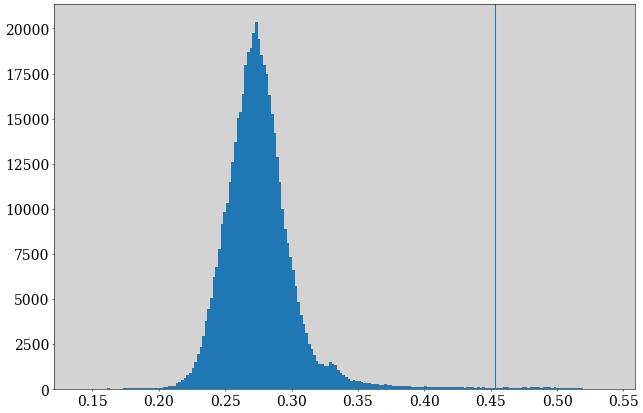

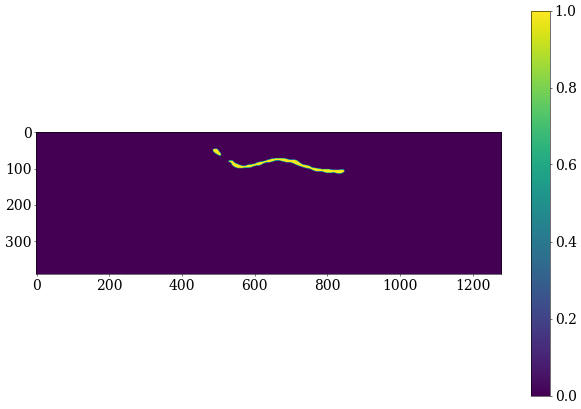

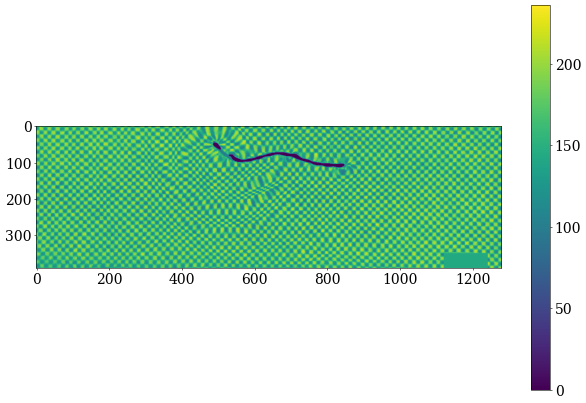

In [207]:


th = threshold_minimum(rec) 
th1 = th - 0.05
# th = 0.5

plt.figure()
plt.hist(rec.flatten(), 200)
plt.axvline(th)

binary = rec>th

print(rec)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.area_closing(binary, 2000)
plt.figure()
# area_
plt.imshow(binary)
plt.colorbar()

print(im*(1-(rec>th)))

plt.figure()
plt.imshow(im*(1-(rec>th)))
plt.colorbar()
